In [5]:
import pandas as pd
import pydicom
import os
from tqdm import tqdm

ORIGINAL_DICOM_FOLDER = r"D:\vinbigdata-chest-xray-abnormalities-detection\train"
ORIGINAL_CSV_PATH = r"D:\vinbigdata-chest-xray-abnormalities-detection\train.csv"
NEW_CSV_PATH = r"D:\vinbigdata-chest-xray-abnormalities-detection\train224.csv"

df = pd.read_csv(ORIGINAL_CSV_PATH)

original_dims = {}

# Preprocess all unique DICOM files
for image_id in tqdm(df['image_id'].unique(), desc="Processing DICOMs"):
    dicom_path = os.path.join(ORIGINAL_DICOM_FOLDER, f"{image_id}.dicom")
    try:
        ds = pydicom.dcmread(dicom_path)
        original_dims[image_id] = (ds.Columns, ds.Rows)
    except Exception as e:
        print(f"Error at {image_id}: {str(e)}")
        original_dims[image_id] = (None, None)

def scale_coordinates(row):
    new_row = row.copy()  # Preserve all original data
    
    # Skip empty boxes (e.g., "No finding")
    if pd.isna(row['x_min']):
        return new_row
    
    original_width, original_height = original_dims[row['image_id']]
    
    # Skip invalid dimensions
    if not original_width or not original_height:
        new_row['x_min'] = new_row['y_min'] = new_row['x_max'] = new_row['y_max'] = None
        return new_row
    
    # Calculate scaling factors
    scale_x = 224 / original_width
    scale_y = 224 / original_height
    
    new_row['x_min'] = max(0, min(round(row['x_min'] * scale_x), 223)) #223 for 224 pixels (224x224 images)
    new_row['y_min'] = max(0, min(round(row['y_min'] * scale_y), 223))
    new_row['x_max'] = max(0, min(round(row['x_max'] * scale_x), 223)) 
    new_row['y_max'] = max(0, min(round(row['y_max'] * scale_y), 223))
    
    return new_row

# Process ALL rows (including duplicates)
scaled_df = df.apply(scale_coordinates, axis=1)

# Save with all entries preserved
scaled_df.to_csv(NEW_CSV_PATH, index=False)
print(f"✅ Scaled {len(df)} entries (including duplicates) to {NEW_CSV_PATH}")


Processing DICOMs:   5%|▍         | 676/15000 [00:30<10:55, 21.86it/s]


KeyboardInterrupt: 

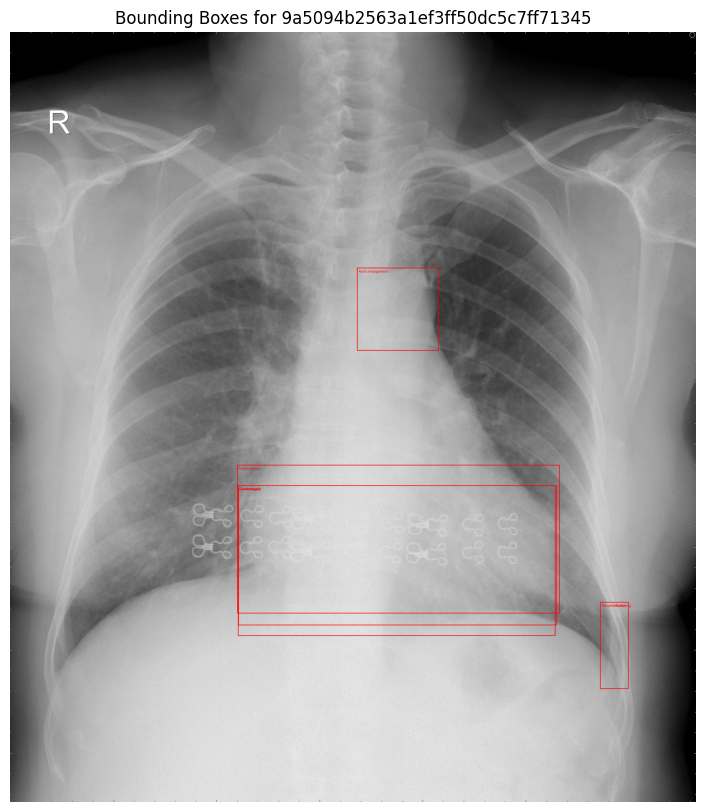

In [8]:
import pandas as pd
import os
import pydicom
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Paths (update these)
ORIGINAL_IMAGE_FOLDER = r"D:\vinbigdata-chest-xray-abnormalities-detection\train_png"  # Update to DICOM folder if needed
ORIGINAL_CSV_PATH = r"D:\vinbigdata-chest-xray-abnormalities-detection\train.csv"

# Load CSV
df = pd.read_csv(ORIGINAL_CSV_PATH)

def load_image(image_id, folder_path, file_extension=".png"):
    image_path = os.path.join(folder_path, f"{image_id}{file_extension}")
    if file_extension == ".dcm":
        # Load DICOM image
        try:
            dicom = pydicom.dcmread(image_path)
            image = dicom.pixel_array  # Get pixel array
            return Image.fromarray(image), (dicom.Columns, dicom.Rows)  # Convert to PIL Image
        except Exception as e:
            print(f"Error loading DICOM: {e}")
            return None, None
    elif file_extension == ".png":
        # Load PNG image
        try:
            img = Image.open(image_path)
            return img, img.size  # Return PIL Image and dimensions (width, height)
        except Exception as e:
            print(f"Error loading PNG: {e}")
            return None, None

def visualize_bounding_boxes(image_id, df, folder_path, file_extension=".png"):
    """
    Visualize bounding boxes for a specific image_id.
    """
    # Load the image
    img, dimensions = load_image(image_id, folder_path, file_extension)
    
    if img is None or dimensions is None:
        print(f"Image {image_id} could not be loaded.")
        return
    
    # Get bounding box entries for this image_id
    bboxes = df[df['image_id'] == image_id]
    
    # Draw bounding boxes on the image
    draw = ImageDraw.Draw(img)
    
    for _, row in bboxes.iterrows():
        if pd.isna(row['x_min']) or pd.isna(row['y_min']) or pd.isna(row['x_max']) or pd.isna(row['y_max']):
            continue  # Skip rows without bounding box coordinates
        
        x_min, y_min, x_max, y_max = row['x_min'], row['y_min'], row['x_max'], row['y_max']
        
        # Draw rectangle (bounding box) on the image
        draw.rectangle([(x_min, y_min), (x_max, y_max)], outline="red", width=2)
        
        # Optionally label the box with class_name or class_id
        label = row['class_name'] if 'class_name' in row else str(row['class_id'])
        draw.text((x_min + 5, y_min + 5), label, fill="red")
    
    # Display the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Bounding Boxes for {image_id}")
    plt.show()

image_id_to_check = "9a5094b2563a1ef3ff50dc5c7ff71345" 
visualize_bounding_boxes(image_id_to_check, df, ORIGINAL_IMAGE_FOLDER)


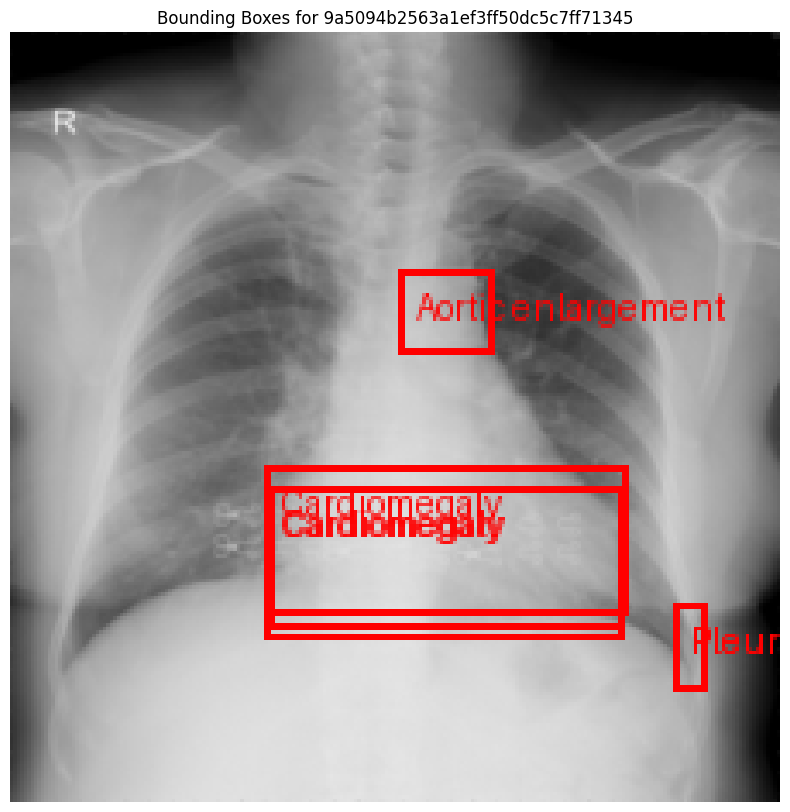

In [9]:
import pandas as pd
import os
import pydicom
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Paths (update these)
ORIGINAL_IMAGE_FOLDER = r"D:\vinbigdata-chest-xray-abnormalities-detection\train_png_224"  # Update to DICOM folder if needed
ORIGINAL_CSV_PATH = r"D:\vinbigdata-chest-xray-abnormalities-detection\train224.csv"

# Load CSV
df = pd.read_csv(ORIGINAL_CSV_PATH)

def load_image(image_id, folder_path, file_extension=".png"):
    image_path = os.path.join(folder_path, f"{image_id}{file_extension}")
    if file_extension == ".dcm":
        # Load DICOM image
        try:
            dicom = pydicom.dcmread(image_path)
            image = dicom.pixel_array  # Get pixel array
            return Image.fromarray(image), (dicom.Columns, dicom.Rows)  # Convert to PIL Image
        except Exception as e:
            print(f"Error loading DICOM: {e}")
            return None, None
    elif file_extension == ".png":
        # Load PNG image
        try:
            img = Image.open(image_path)
            return img, img.size  # Return PIL Image and dimensions (width, height)
        except Exception as e:
            print(f"Error loading PNG: {e}")
            return None, None

def visualize_bounding_boxes(image_id, df, folder_path, file_extension=".png"):
    """
    Visualize bounding boxes for a specific image_id.
    """
    # Load the image
    img, dimensions = load_image(image_id, folder_path, file_extension)
    
    if img is None or dimensions is None:
        print(f"Image {image_id} could not be loaded.")
        return
    
    # Get bounding box entries for this image_id
    bboxes = df[df['image_id'] == image_id]
    
    # Draw bounding boxes on the image
    draw = ImageDraw.Draw(img)
    
    for _, row in bboxes.iterrows():
        if pd.isna(row['x_min']) or pd.isna(row['y_min']) or pd.isna(row['x_max']) or pd.isna(row['y_max']):
            continue  # Skip rows without bounding box coordinates
        
        x_min, y_min, x_max, y_max = row['x_min'], row['y_min'], row['x_max'], row['y_max']
        
        # Draw rectangle (bounding box) on the image
        draw.rectangle([(x_min, y_min), (x_max, y_max)], outline="red", width=2)
        
        # Optionally label the box with class_name or class_id
        label = row['class_name'] if 'class_name' in row else str(row['class_id'])
        draw.text((x_min + 5, y_min + 5), label, fill="red")
    
    # Display the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Bounding Boxes for {image_id}")
    plt.show()

image_id_to_check = "9a5094b2563a1ef3ff50dc5c7ff71345" 
visualize_bounding_boxes(image_id_to_check, df, ORIGINAL_IMAGE_FOLDER)